Exploring whether there are any valid/natural clusters for the keywords mentioned in [Q1], that could help identify/categorize corporate culture.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re, nltk, operator, itertools, gensim, math
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from operator import itemgetter
from gensim import corpora, models

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [ ]:
def strfy(x):
    return x.fillna(".").map(str)


df = pd.read_csv('corporate_culture_trunc.csv', encoding='latin-1') #reads csv into dataframe
df = df.dropna(subset=['Q1']) #drop row if no description (NaN in Q1)
dfs = df.Q1
dfs = [dfs1.encode('utf-8') for dfs1 in dfs]
df.Q1 = dfs

##LETS MERGE TEXT TOGETHER
df['merge_text'] = df.Q1.map(str)+strfy(df.Q6_Other)+strfy(df.Q13_5_Other)+strfy(df.Q14_Other)
df['merge_text'] = df['merge_text']+strfy(df.Q14_OE_2)+strfy(df.Q14_OE_3)+strfy(df.Q14_OE_5)+strfy(df.Q14_OE_6)+strfy(df.Q14_OE_7)+strfy(df.Q14_OE_8)+strfy(df.Q14_OE_9)+strfy(df.Q14_OE_11)+strfy(df.Q14_OE_12)

df = df.drop(['Q6_Other','Q13_5_Other','Q14_Other','Q14_OE_1','Q14_OE_2','Q14_OE_3','Q14_OE_4','Q14_OE_5','Q14_OE_6','Q14_OE_7','Q14_OE_8','Q14_OE_9','Q14_OE_10','Q14_OE_9','Q14_OE_10','Q14_OE_11','Q14_OE_12'],axis=1)


In [23]:
def strfy(x):
    return x.fillna(".").map(str)


df = pd.read_csv('corporate_culture_trunc.csv', encoding='latin-1') #reads csv into dataframe
df = df.dropna(subset=['Q1']) #drop row if no description (NaN in Q1)
dfs = df.Q1
dfs = [dfs1.encode('utf-8') for dfs1 in dfs]
df.Q1 = dfs

##LETS MERGE TEXT TOGETHER
df['merge_text'] = df.Q1.map(str)+strfy(df.Q6_Other)+strfy(df.Q13_5_Other)+strfy(df.Q14_Other)
df['merge_text'] = df['merge_text']+strfy(df.Q14_OE_2)+strfy(df.Q14_OE_3)+strfy(df.Q14_OE_5)+strfy(df.Q14_OE_6)+strfy(df.Q14_OE_7)+strfy(df.Q14_OE_8)+strfy(df.Q14_OE_9)+strfy(df.Q14_OE_11)+strfy(df.Q14_OE_12)

df = df.drop(['Q6_Other','Q13_5_Other','Q14_Other','Q14_OE_1','Q14_OE_2','Q14_OE_3','Q14_OE_4','Q14_OE_5','Q14_OE_6','Q14_OE_7','Q14_OE_8','Q14_OE_9','Q14_OE_10','Q14_OE_9','Q14_OE_10','Q14_OE_11','Q14_OE_12'],axis=1)


In [38]:
####
culture_text2 = df.Q1 #Carrying out analysis just on the text in Q1
culture_text=df.merge_text

In [39]:
###BELOW COMMANDS CARRY OUT THE STANDARD NLP IN ORDER TO VIEW THE TEXTUAL DATA IN MATRIX FORM#########

lmtzr = WordNetLemmatizer() #lemmatizes words
estopwords = set(stopwords.words('english')) #gets rid of stopwords (a, an, the...)
ostopwords = ['wa','ha']

def removewords(docwords,nmin,nmax):
    #removes words above or below certain threshold
    all_tokens=sum(docwords,[])
    tokens_n=set(word for word in set(all_tokens) if all_tokens.count(word)<=nmin or all_tokens.count(word)>=nmax)
    docwords = [[word for word in docs if word not in tokens_n]
                for docs in docwords]
    return docwords

def lemmat(corpus):
    #tokenizes and lemmatizes words, removes those above or below certain threshold
    nmin = 4
    nmax = len(corpus)/2
    token_corpus = [[re.sub(r'[^\w\-\s]','', word) for word in doc.lower().split()]
          for doc in corpus]
    token_corpus = [[lmtzr.lemmatize(w) for w in doc]
                for doc in token_corpus]
    token_corpus = [[w for w in doc if len(w)>1] #getting rid of words with only one letter
            for doc in token_corpus]
    token_corpus = [[w for w in doc if w not in estopwords] #getting rid of stopwords
            for doc in token_corpus]
    token_corpus = [[w for w in doc if w not in ostopwords] #getting rid of stopwords
            for doc in token_corpus]
    token_corpus = removewords(token_corpus,nmin,nmax)
    return(token_corpus)

tcorpus = lemmat(culture_text)
tcorpus = [doc for doc in tcorpus if len(doc)>0] #get rid of observations with no values
print(len(tcorpus)) #TOTAL OBSERVATIONS
print("The first ten results:")
print(tcorpus[0:10])

1679
The first ten results:
[['integrity', 'professionalism', 'develop', u'system'], ['want', u'customer', 'understand', u'need', u'commitment', 'innovative', u'solution', 'top', 'quality', u'product', u'service', 'competitive'], ['chaos', 'past', 'since', 'growing', 'fast', 'change', 'process', 'order', 'corporate', 'culture'], ['success', 'team', 'effort'], ['dynamic', 'startup', 'culture', 'little', 'hierarchy'], ['diversity', 'excellence', 'transparent', u'disclosure', 'provided', u'investor', 'required'], ['positive', u'attitude'], ['open', 'collaborative', 'professional', 'cooperative', 'sharing', 'direction', 'given', u'employee', 'take', u'risk', 'job', u'number', 'take', 'care', 'also', u'employee', 'free', u'superior', 'without', 'fear', 'negatively'], ['reporting', u'drive', 'front', 'end', u'action', 'new', u'initiative', 'ever', 'taken'], ['family', 'oriented', 'culture', u'need', 'done', 'deliver', 'customer', 'service', 'right', 'culture', 'use', 'capital', u'deal', 'bel

In [40]:
def joinlists(listname):
    #function for joining list of lists (i.e. from x=([['a','b'],['c']]) to x=['a','b','c'])
    #want only unique values for each document, so:
    uniquelitems = [set(listitems) for listitems in listname]
    newlist=list(itertools.chain.from_iterable(uniquelitems))
    return newlist

def word_count(toktext): 
    #function returns word frequences from an input of tokenized text
    word_freq=dict([(word, toktext.count(word)) for word in set(toktext)])
    return word_freq

def top_words(toktext,n):
    #function returns top n words in a tokenized text
    wordfreq=word_count(toktext)
    topwords=sorted(wordfreq.iteritems(),key=itemgetter(1), reverse=True)[:n]
    return topwords

tot_allwords=joinlists(tcorpus)

print("Top 100 words:")
for ind_word in top_words(tot_allwords,100):
    print ind_word

Top 100 words:
('culture', 381)
(u'employee', 235)
('work', 206)
(u'risk', 191)
('company', 171)
(u'customer', 171)
('team', 135)
('value', 129)
('business', 129)
('project', 128)
('collaborative', 128)
('growth', 125)
('people', 124)
('family', 112)
('open', 110)
('management', 106)
('corporate', 103)
('take', 99)
('integrity', 98)
('focused', 97)
('oriented', 96)
('new', 90)
(u'service', 86)
(u'result', 85)
('goal', 81)
('focus', 79)
('client', 79)
('driven', 78)
('high', 77)
('productivity', 75)
(u'make', 75)
('financial', 74)
('time', 73)
(u'decision', 73)
('one', 71)
(u'need', 66)
('change', 65)
('working', 65)
('quality', 64)
(u'term', 63)
('firm', 63)
('right', 62)
('respect', 61)
('top', 60)
('professional', 60)
('environment', 57)
('entrepreneurial', 57)
('lack', 56)
('organization', 56)
('accountability', 56)
('innovative', 55)
('thing', 55)
('get', 55)
(u'good', 54)
('based', 54)
('reporting', 54)
('conservative', 53)
('level', 52)
('performance', 52)
('teamwork', 52)
('prof

In [41]:
dictionary = corpora.Dictionary(tcorpus)
dictionary.save('culturewords.dict') # store the dictionary, for future reference
corpus = [dictionary.doc2bow(text) for text in tcorpus]
corpora.BleiCorpus.serialize('culturewords.lda-c', corpus) # store to disk, for later use
#corpus is now in bag-of-words format (number of occurrances of each word in the dictionary in each document)

tfidf = models.TfidfModel(corpus)
corpus_tfidf=tfidf[corpus]

(1679, 909)


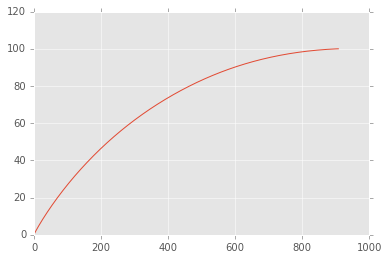

In [42]:
### CAN WE FIGURE OUT A NATURAL NUMBER OF CLUSTERS FROM THE DATA?
### LETS DO PCA AND THEN DETERMINE HOW MANY PRINCIPAL COMPONENTS TO CHOOSE
### VIA EXPLAINED VARIANCE MEASURES, CALCULATED FROM THE EIGENVALUES
### (The explained variance tells us how much information (variance) can be attributed 
### to each of the principal components.)

numpy_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
X = numpy_matrix.transpose() #each observation a row, each feature a column
X_std = StandardScaler().fit_transform(X)
print(X.shape) #401 features, 1567 observations

mean_vec = np.mean(X, axis=0)
cov_mat = (X - mean_vec).T.dot((X - mean_vec)) / (X.shape[0]-1)
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.plot(cum_var_exp)

The plot of Explained variance is too smooth -- not able to carry out dimension reduction or come up with a reasonable value for number of clusters

Reading more -- kmeans is a horrible clustering algorithm for categorical/ordinal data, which is basically what textual data is converted to. Lets try other methods for calculating number of clusters and their components.

# DBSCAN CLUSTERING

PERHAPS DBSCAN (Density-Based Spatial Clustering of Applications with Noise) WOULD BE A BETTER CLUSTERING METHOD?

Density-based clustering algorithms attempt to capture our intuition that a cluster is a region of the data space where there are lots of points, surrounded by a region where there are few points. 

DBSCAN does this by partitioning the input data points into three types:
(1) Core points have a large number of other points within a given neighborhood. The parameter min_core_neighbors defines how many points counts as a "large number", while the radius parameter defines how large the neighborhoods are around each point. Specifically, a point y is in the neighborhood of point x if d(x,y)< radius, where d is a user-specified distance function.
(2) Boundary points are within distance radius of a core point, but don't have sufficient neighbors of their own to be considered core.
(3) Noise points comprise the remainder of the data. These points have too few neighbors to be considered core points, and are further than distance radius from all core points.


In [43]:
# Compute DBSCAN
db = DBSCAN(min_samples=15).fit(X_std)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_std, labels))

#Silhouette coefficient near 0, indicating overlapping clusters

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Too much noise, not enough signal, being captured via this clustering method.
When clustering just Q1, get 3 estimated number of clusters. When clustering all text, 0.

# TOPIC MODELING

In [44]:
##LDA assumes that a company can belong to more than one cluster (more than one type of culture).
##The results of the DBScan indicated there was overlap, so let us try this, first, with three clusters.

num_topics=3

ldamodel = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, passes=20, iterations=100000)
ldamodel.print_topics()

[(0,
  u'0.020*collaborative + 0.009*culture + 0.009*innovative + 0.009*performance + 0.008*driven + 0.008*growth + 0.008*open + 0.007*term + 0.007*company + 0.007*high'),
 (1,
  u'0.012*culture + 0.011*customer + 0.010*risk + 0.009*employee + 0.007*people + 0.007*conservative + 0.007*value + 0.007*corporate + 0.006*good + 0.006*work'),
 (2,
  u'0.023*family + 0.015*team + 0.013*integrity + 0.011*oriented + 0.011*friendly + 0.011*work + 0.010*entrepreneurial + 0.009*professional + 0.008*employee + 0.008*teamwork')]

These don't seem very valid. Next, I tried LDA with seven clusters/topics, as in the paper/ppt.

In [45]:
num_topics=7

ldamodel = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics, passes=20, iterations=100000)
ldamodel.print_topics()


[(0,
  u'0.019*integrity + 0.012*traditional + 0.011*honesty + 0.011*quality + 0.009*innovation + 0.009*best + 0.009*trust + 0.009*high + 0.009*respect + 0.007*culture'),
 (1,
  u'0.016*entrepreneurial + 0.010*important + 0.009*changing + 0.009*informal + 0.008*global + 0.007*mission + 0.007*top + 0.006*focused + 0.006*growth + 0.006*individual'),
 (2,
  u'0.017*collegial + 0.012*culture + 0.012*caring + 0.011*service + 0.010*engaged + 0.010*customer + 0.009*business + 0.009*growth + 0.008*competitive + 0.008*client'),
 (3,
  u'0.024*family + 0.010*culture + 0.010*good + 0.010*company + 0.010*conservative + 0.009*value + 0.009*employee + 0.008*relaxed + 0.008*people + 0.007*strong'),
 (4,
  u'0.012*work + 0.011*oriented + 0.011*professional + 0.010*employee + 0.009*customer + 0.009*member + 0.008*management + 0.008*family + 0.008*casual + 0.007*sense'),
 (5,
  u'0.010*work + 0.010*culture + 0.010*risk + 0.010*time + 0.009*take + 0.009*employee + 0.009*hard + 0.008*corporate + 0.008*exc

These don't shed much light, either; very difficult to tell at a glance what differentiates the different clusters.

It also brings up the question -- does it really make sense to use LDA in this model? Do we want to give each company's culture one label, or allow it to have multiple labels? Nevertheless, lets keep going on this route.

In [46]:
##TOPIC MODELING VIA LSI.

lsimodel = models.lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsimodel[corpus_tfidf]
lsimodel.print_topics(num_topics)

[(0,
  u'0.267*"collaborative" + 0.250*"culture" + 0.210*"family" + 0.204*"employee" + 0.182*"customer" + 0.180*"oriented" + 0.170*"team" + 0.167*"work" + 0.142*"risk" + 0.139*"company"'),
 (1,
  u'0.920*"collaborative" + -0.128*"family" + 0.084*"oriented" + -0.083*"culture" + -0.071*"work" + 0.068*"conservative" + -0.061*"company" + 0.059*"open" + -0.052*"corporate" + -0.052*"business"'),
 (2,
  u'-0.891*"family" + -0.261*"oriented" + 0.084*"integrity" + 0.080*"culture" + -0.077*"friendly" + 0.076*"employee" + -0.067*"owned" + 0.067*"risk" + 0.066*"company" + -0.056*"team"'),
 (3,
  u'-0.899*"entrepreneurial" + -0.198*"innovative" + -0.111*"oriented" + -0.099*"team" + 0.096*"employee" + 0.088*"work" + 0.086*"collaborative" + 0.079*"customer" + -0.068*"driven" + -0.063*"see"'),
 (4,
  u'0.629*"open" + -0.304*"customer" + 0.275*"friendly" + -0.254*"oriented" + -0.221*"service" + -0.164*"integrity" + -0.145*"focused" + -0.145*"driven" + 0.139*"transparent" + 0.119*"collegial"'),
 (5,
  u

The negatives actually tell us a bit more than expected, since it shows how much that particular type of culture varies from the baseline/norm values for the particular value being measured (collaborativeness, family, etc)

In [47]:
num_topics=3

lsimodel = models.lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsimodel[corpus_tfidf]
lsimodel.print_topics(num_topics)

[(0,
  u'0.267*"collaborative" + 0.250*"culture" + 0.210*"family" + 0.204*"employee" + 0.182*"customer" + 0.180*"oriented" + 0.170*"team" + 0.167*"work" + 0.141*"risk" + 0.139*"company"'),
 (1,
  u'-0.921*"collaborative" + 0.128*"family" + -0.084*"oriented" + 0.083*"culture" + 0.073*"work" + -0.067*"conservative" + 0.061*"company" + -0.059*"open" + 0.052*"corporate" + 0.050*"integrity"'),
 (2,
  u'0.890*"family" + 0.262*"oriented" + -0.084*"integrity" + -0.081*"culture" + 0.079*"friendly" + -0.074*"employee" + 0.067*"owned" + -0.065*"risk" + -0.064*"company" + 0.057*"team"')]

In [50]:
#HDP model, which uncovers its own number of clusters.
#in this model, it uncovered too many distinct topics to count.
#however, none seem to be very valid topics.
#only showing top 10

hdpmodel = models.hdpmodel.HdpModel(corpus=corpus_tfidf, id2word=dictionary)
corpus_hp = hdpmodel[corpus_tfidf]
hdpmodel.print_topics(10)

[u'topic 0: 0.010*improvement + 0.008*never + 0.007*mind + 0.006*fit + 0.006*deal + 0.006*bottom + 0.006*know + 0.006*expertise + 0.006*thing + 0.006*respectful + 0.005*professional + 0.005*back + 0.005*involved + 0.005*customer-centric + 0.005*generate + 0.005*number + 0.005*willingness + 0.005*simple + 0.005*hr + 0.004*significant',
 u'topic 1: 0.009*strategy + 0.007*interaction + 0.006*corporate + 0.006*cohesive + 0.006*balance + 0.006*mutual + 0.005*activity + 0.005*needed + 0.005*drive + 0.005*left + 0.005*real + 0.005*entrepreneurial + 0.005*rate + 0.005*accountable + 0.005*result + 0.005*think + 0.004*authority + 0.004*expense + 0.004*keep + 0.004*timely',
 u'topic 2: 0.007*committed + 0.007*timely + 0.006*corp + 0.006*shared + 0.006*surprise + 0.005*hierarchy + 0.005*experienced + 0.005*program + 0.005*service + 0.005*trusting + 0.005*casual + 0.005*employee + 0.005*source + 0.005*effect + 0.005*freedom + 0.004*focused + 0.004*rd + 0.004*belief + 0.004*outside + 0.004*delay',
 

In [51]:
###KMEANS CLUSTERING, JUST FOR THE HECK OF IT

num_clusters = 3

numpy_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
X = numpy_matrix.transpose() #each observation a row, each feature a column

km = KMeans(n_clusters=num_clusters)

%time km.fit(X)

clusters = km.labels_.tolist()
dfc = { 'cluster_no' : pd.Series(clusters),
        'culture_text': pd.Series(tcorpus)}
dfc = pd.DataFrame(dfc)
cluster_one = dfc.loc[dfc['cluster_no'] == 0]['culture_text']
print(len(cluster_one))
tot_allwords=joinlists(cluster_one)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_two = dfc.loc[dfc['cluster_no'] == 1]['culture_text']
print(len(cluster_two))
tot_allwords=joinlists(cluster_two)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_three = dfc.loc[dfc['cluster_no'] == 2]['culture_text']
print(len(cluster_three))
tot_allwords=joinlists(cluster_three)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word


CPU times: user 7.61 s, sys: 84.4 ms, total: 7.69 s
Wall time: 1.95 s
871
Top 10 words:
('work', 103)
('family', 81)
(u'open', 76)
('people', 71)
('team', 70)
('integrity', 53)
('value', 50)
('professional', 43)
(u'employee', 40)
('hard', 39)
58
Top 10 words:
('collaborative', 58)
('oriented', 10)
('team', 7)
('employee', 5)
('culture', 5)
('conservative', 5)
('driven', 4)
('mission', 3)
('respectful', 3)
('supportive', 3)
750
Top 10 words:
('culture', 339)
(u'employee', 190)
(u'risk', 179)
(u'customer', 155)
('company', 150)
('project', 112)
('work', 102)
('business', 101)
('corporate', 98)
('growth', 91)


This gives an indication of why the clusters are so crappy. Essentially, one cluster was formed solely on the basis that people put "collaborative" on their surveys (while excluding some other words such as, presumably, 'culture', 'employee', 'customer', 'company', 'project', 'work', etc).

Obviously this is not an ideal clustering method.

In [52]:
num_clusters = 7
numpy_matrix = gensim.matutils.corpus2dense(corpus_tfidf, num_terms=len(dictionary))
X = numpy_matrix.transpose() #each observation a row, each feature a column

km = KMeans(n_clusters=num_clusters)

%time km.fit(X)

clusters = km.labels_.tolist()
dfc = { 'cluster_no' : pd.Series(clusters),
        'culture_text': pd.Series(tcorpus)}
dfc = pd.DataFrame(dfc)
cluster_one = dfc.loc[dfc['cluster_no'] == 0]['culture_text']
print(len(cluster_one))
tot_allwords=joinlists(cluster_one)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_two = dfc.loc[dfc['cluster_no'] == 1]['culture_text']
print(len(cluster_two))
tot_allwords=joinlists(cluster_two)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_three = dfc.loc[dfc['cluster_no'] == 2]['culture_text']
print(len(cluster_three))
tot_allwords=joinlists(cluster_three)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_four = dfc.loc[dfc['cluster_no'] == 3]['culture_text']
print(len(cluster_four))
tot_allwords=joinlists(cluster_four)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_five = dfc.loc[dfc['cluster_no'] == 4]['culture_text']
print(len(cluster_five))
tot_allwords=joinlists(cluster_five)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_six = dfc.loc[dfc['cluster_no'] == 5]['culture_text']
print(len(cluster_six))
tot_allwords=joinlists(cluster_six)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_seven = dfc.loc[dfc['cluster_no'] == 6]['culture_text']
print(len(cluster_seven))
tot_allwords=joinlists(cluster_seven)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

CPU times: user 9.38 s, sys: 140 ms, total: 9.52 s
Wall time: 2.42 s
262
Top 10 words:
(u'risk', 145)
('take', 73)
('project', 72)
('people', 62)
('culture', 59)
('company', 45)
(u'term', 42)
('long', 34)
('management', 32)
('growth', 32)
401
Top 10 words:
('culture', 241)
('work', 139)
(u'employee', 128)
('corporate', 77)
(u'company', 76)
('business', 69)
('one', 49)
('growth', 49)
('goal', 47)
('value', 46)
58
Top 10 words:
('family', 58)
('oriented', 14)
('work', 7)
('friendly', 6)
('owned', 6)
('atmosphere', 5)
('team', 5)
('environment', 4)
('community', 4)
('like', 4)
52
Top 10 words:
('collaborative', 52)
('oriented', 8)
('team', 6)
('culture', 4)
('conservative', 4)
('driven', 4)
('supportive', 3)
('mission', 3)
('fun', 3)
('ethical', 2)
78
Top 10 words:
('integrity', 76)
('respect', 20)
('culture', 20)
('employee', 14)
('accountability', 12)
('teamwork', 12)
('high', 10)
('honesty', 9)
('work', 9)
(u'value', 9)
162
Top 10 words:
(u'customer', 86)
('oriented', 46)
(u'service', 

In [217]:
## As above shows, we're running into the problem of synonyms
## collaborative & supportive & team are essentially the same
## yet there isn't enough data for the model to pick up on that

## Perhaps hierarchical clustering algorithms would work better?

# Hierarchical clustering

(1679, 909)


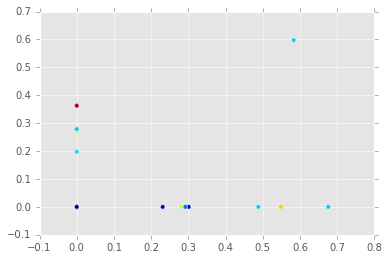

0.0859422022491
0.539807183178


In [53]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet

print(X.shape)
Z = linkage(X,'ward')
Zcos = linkage(X,metric='cosine',method='complete')
labels = fcluster(Zcos, .1, criterion="distance")
plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float)) 
plt.show()

c, coph_dists = cophenet(Z,pdist(X))
print(c)
c, coph_dists = cophenet(Zcos,pdist(X))
print(c) 

The Cophenetic Correlation Coefficient compares (correlates) the actual pairwise distances of all our samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances. We will go with the cos distance, since that is more standard for text, and also closer to one. However, as this number shows, there's a significant account of variation left unaccounted for.

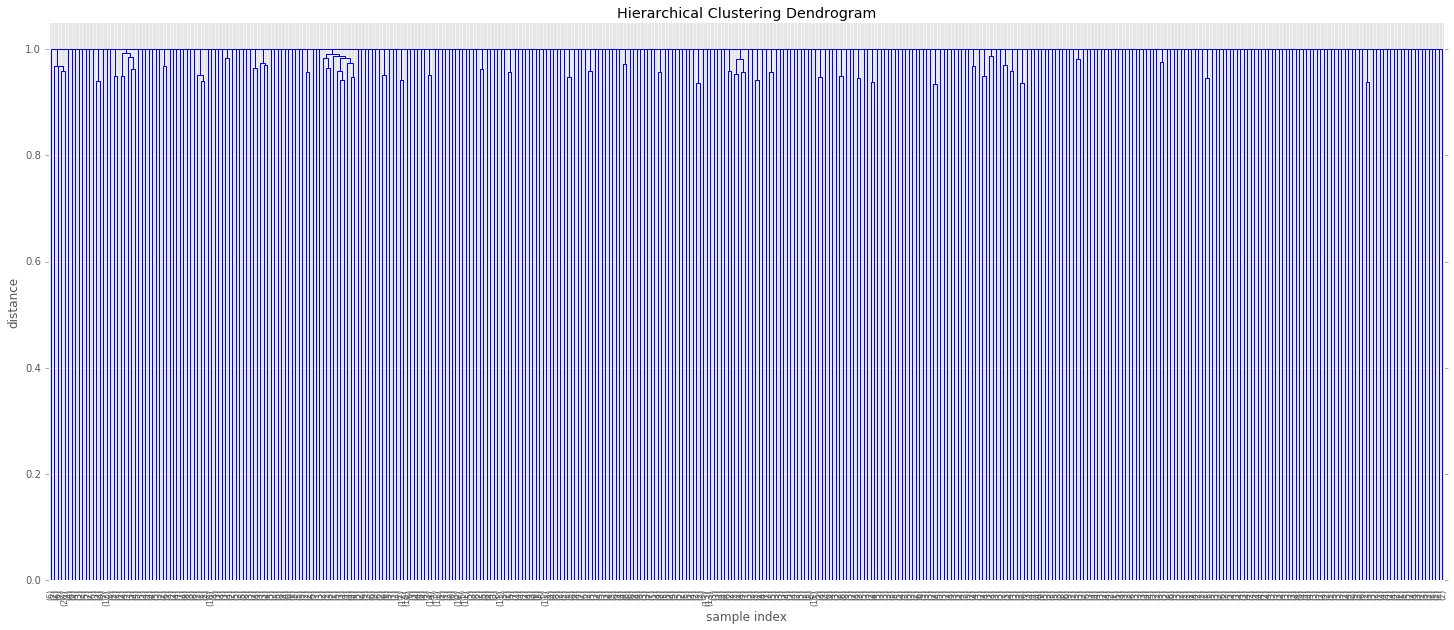

In [54]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Zcos,
    truncate_mode = 'lastp',
    p=400,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

Takeaway: There are too many clusters, and no principled way to decrease that number. Perhaps if we include other non-textual variables?